# Attention-based Marker Gene Detection Inference on FEFT(Parameter-Efficient Fine-Tuning) Model
Here we use the peft scGPT model on the Tonsil_MBC dataset as an example of the marker gene detection via attention weights. scGPT outputs attention weights on the individual cell level, which can be further aggregated by cell states. In this analysis, we compare csMBC FCRL4/5+ cells as the target population.

Users may perform peft scGPT's attention-based marker gene detection in the following steps:

     1. Load peft scGPT model and data
     
     2. Retrieve scGPT's attention weights 
     
     3. Export marker genes derived from attention weights


In [20]:
import json
import os
from pathlib import Path
import sys
from typing import List, Tuple, Dict, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from tqdm import tqdm
from torch import nn
from einops import rearrange
from torch.nn import functional as F

sys.path.insert(0, "../../")
import scgpt as scg
from scgpt.model import TransformerModel
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import TFPreprocessor
from scgpt.utils import set_seed, load_tfs, PeftConfig

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

In [21]:
set_seed(42)
dataset_name = "MBC"  # Dataset name
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_value = -1
pad_value = -2
n_bins = 51 
batch_size = 20
n_input_bins = n_bins
include_zero_gene = False  # if True, include zero genes among hvgs in the training
peft_config = PeftConfig(peft_type="HYBRID").to_dict()

## Step 1: Load peft model and dataset

We are going to load a peft scGPT model for the cell population discovery on Tonsil_MBC dataset. The peft model can be downloaded via this [link](https://drive.google.com/drive/folders/1lFphh2ed99UYDGGdhmDy4DtHo5P4BcWo?usp=sharing). The Tonsil_MBC dataset can be downloaded via this [link](https://drive.google.com/file/d/1-xj4l4Y8r8BAzZJxYwPhWaqZSk9mLiXc/view?usp=sharing).

To reproduce the provided peft model. Please follow the cell population discovery pipeline to peft(HYBRID ADAPTER as default) the pre-trained whole human model on the Tonsil_MBC dataset.  

In [22]:
load_model = "../save/peft_scGPT_MBC_marker_gene_detection"  # Path to peft model
save_dir = Path(f"./save/marker_gene_detection_{dataset_name}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/marker_gene_detection_MBC


In [23]:
if dataset_name == 'MBC':
    data_dir = Path("../data/marker_gene_detection")
    adata = sc.read(data_dir / f"{dataset_name}.h5ad")

    n_hvg = 2000  # number of highly variable genes
    data_is_raw = False
    filter_gene_by_counts = 3
    adata.obs["str_batch"] = adata.obs["assay"]
    adata.obs["celltype"] = adata.obs["annotation_20230508"]
    adata.var["gene_name"] = adata.var.index.tolist()

    prior_markers = [
        'GSN', 'IGHG', 'TNFRSF13B',
        'SOX5', 'HCK', 'IGHM', 'FCER2',
        'IGHA', 'FGR', 'IGHA1', 'FCRL5',
        'IGHD', 'FCRL4', 'CD27', 'IGHG1', 'TCLA1'
    ]
    prior_markers = [pm for pm in prior_markers if pm in adata.var.index.tolist()]

if dataset_name == 'COVID':
    data_dir = Path("../data/marker_gene_detection")
    adata = sc.read(data_dir / f"{dataset_name}.h5ad")

    n_hvg = False
    data_is_raw = True
    filter_gene_by_counts = False
    adata.obs["celltype"] = adata.obs["cell_type"].astype("category")
    adata.var["gene_name"] = adata.var.index.tolist()


In [24]:
if load_model is not None:
    model_dir = Path(load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    # shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)

    # load tfs
    tfs_file_path = Path("human_transcription_factors.txt")
    tfs = load_tfs(tfs_file_path, vocab)
    logger.info(f"Load human transcription factors from {tfs_file_path}")

    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

scGPT - INFO - match 23495/23530 genes in vocabulary of size 60697.
scGPT - INFO - Load human transcription factors from human_transcription_factors.txt


In [25]:
# set up the TFpreprocessor, use the args to config the workflow
preprocessor = TFPreprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
    tfs=tfs if dataset_name == 'MBC' else None,  # whether add tfs to the gene set
    prior_markers=prior_markers if dataset_name == 'MBC' else None  # whether add prior markers to the gene set
)

adata = preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Appending prior markers to gene list ...
scGPT - INFO - Appending transcription factor to gene list ...
scGPT - INFO - Binning data ...


In [26]:
genes = adata.var["gene_name"].tolist()
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ntokens = len(vocab)  # size of vocabulary

model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
    use_fast_transformer=False,
    peft_config=peft_config
)

try:
    model.load_state_dict(torch.load(model_file, map_location=device))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file, map_location=device)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params value_encoder.adapter.fc1.weight with shape torch.Size([128, 512])
Loading params value_encoder.adapter.fc1.bias with shape torch.Size([128])
Loading params value_encoder.adapter.fc2.weight with shape torch.Size([512, 128])
Loading params value_encoder.adapter.fc2.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (adapter): Adapter(
      (act): GELU(approximate='none')
      (fc1): Linear(in_features=512, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (transformer_encoder): PeftTransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x PeftTransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_featur

In [28]:
def extract_embedding(
        model: nn.Module,
        adata_t: AnnData,
        batch_size: int,
        include_types: List[str] = ["cls"],
) -> Optional[AnnData]:
    """extract_embedding on dataset of adata_t"""
    model.eval()

    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=len(genes) + 1,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=include_zero_gene,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=batch_size,
                batch_labels=None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

    return adata_t

def extract_attention(
        model: nn.Module,
        batch_size: int = 1,
        num_attn_layers: int = 11,
        return_new_adata: bool = True,
) -> Optional[AnnData]:
    """extract_attention on dataset of adata_t"""

    cell_gene_correlations = []

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
        M = all_gene_ids.size(1)
        N = all_gene_ids.size(0)

        for i in tqdm(range(0, N, batch_size), desc="Embedding attention scores"):
            # Replicate the operations in model forward pass
            src_embs = model.encoder(torch.tensor(all_gene_ids[i: i + batch_size], dtype=torch.long).to(device))
            val_embs = model.value_encoder(torch.tensor(all_values[i: i + batch_size], dtype=torch.float).to(device))
            total_embs = src_embs + val_embs
            # Send total_embs to attention layers for attention operations
            # Retrieve the output from second to last layer
            for layer in model.transformer_encoder.layers[:num_attn_layers]:
                total_embs = layer(total_embs, src_key_padding_mask=src_key_padding_mask[i: i + batch_size].to(device))

            # Send total_embs to the last layer in native-attn
            attn_weight = model.transformer_encoder.layers[num_attn_layers].self_attn.in_proj_weight
            attn_bias = model.transformer_encoder.layers[num_attn_layers].self_attn.in_proj_bias
            qkv = F.linear(total_embs, attn_weight, attn_bias)

            # qkv = model.transformer_encoder.layers[num_attn_layers].self_attn.Wqkv(total_embs)
            # Retrieve q, k, and v from native-attn wrapper
            qkv = rearrange(qkv, 'b s (three h d) -> b s three h d', three=3, h=8)
            q = qkv[:, :, 0, :, :]
            k = qkv[:, :, 1, :, :]
            v = qkv[:, :, 2, :, :]

            attn_scores = q.permute(0, 2, 1, 3) @ k.permute(0, 2, 3, 1)
            # Max 8 attention heads
            attn_scores = attn_scores.max(1)[0]
            # Except cls token
            outputs = attn_scores[:, 1:, 0].detach().cpu().numpy()
            cell_gene_correlations.append(outputs)

    cell_gene_correlations = np.concatenate(cell_gene_correlations, axis=0)
    gene_ids_except_cls = all_gene_ids.clone().detach().cpu().numpy()[:, 1:]
    cell_gene_correlations_X = np.zeros((N, len(gene_ids)), dtype=np.float32)

    for i in range(N):
        align_indices = np.where(np.isin(gene_ids, gene_ids_except_cls[i]))[0]
        for j, idx in enumerate(align_indices):
            cell_gene_correlations_X[i, idx] = cell_gene_correlations[i][j]

    if return_new_adata:
        return sc.AnnData(X=cell_gene_correlations_X, obs=adata.obs, var=adata.var, dtype="float32")

    return None


In [29]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)

tokenized_all = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=len(genes) + 1,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)

logger.info(
    f"data set number of samples: {tokenized_all['genes'].shape[0]}, "
    f"feature length: {tokenized_all['genes'].shape[1]}"
)

scGPT - INFO - data set number of samples: 30393, feature length: 899


Here we visualize the cell type labels over the peft scGPT cell embeddings

In [30]:
adata_t = extract_embedding(
    model,
    adata_t=adata,
    batch_size=batch_size,
    include_types=["cls"],
)

scGPT - INFO - Evaluating cls cell embeddings


100%|██████████| 1520/1520 [02:02<00:00, 12.41it/s]


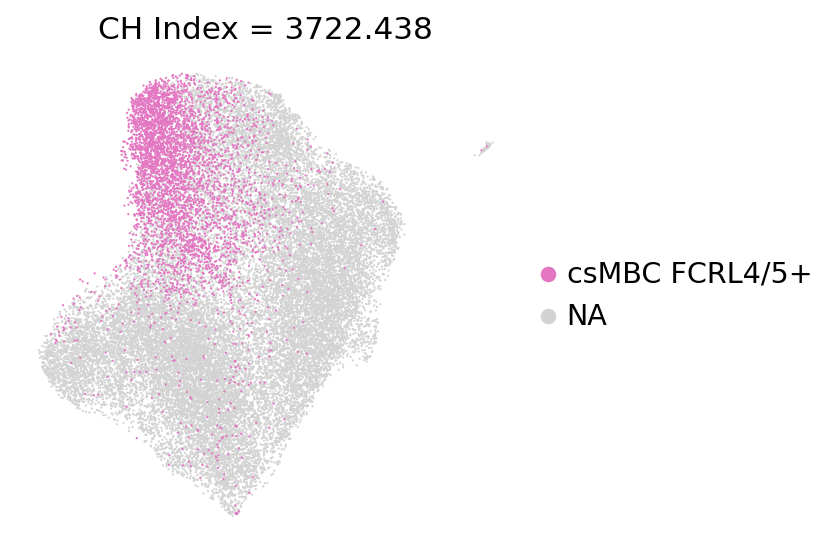

In [32]:
labels = adata_t.obs["celltype"].tolist()
labels = [1 if label == "csMBC FCRL4/5+" else 0 for label in labels ]

from sklearn.metrics import calinski_harabasz_score
CalinskiHarabaszScore = calinski_harabasz_score(X=adata_t.obsm["X_scGPT"], labels=labels)

sc.pp.neighbors(adata_t, use_rep="X_scGPT")
sc.tl.umap(adata_t, min_dist=0.3)

sc.pl.umap(
    adata_t, 
    color=["celltype"], 
    groups="csMBC FCRL4/5+",
    title=[f"CH Index = {round(CalinskiHarabaszScore,4)}"],
    frameon=False,
    show=True
)

## Step 2: Retrieve scGPT's attention weights 
Note that we manually calculate q @ k.T to extract the attention weights. Users may specify which layer to extract the attention weights from. In the manuscript, we used the attention weights from the last (12th) layer.

In [33]:
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

# Use this argument to specify which layer to extract the attention weights from
# Default to 11, extraction from the last (12th) layer. Note that index starts from 0
num_attn_layers = 11

attn_adata = extract_attention(
    model=model,
    batch_size=batch_size,
    num_attn_layers=num_attn_layers,
    return_new_adata=True
)

Embedding attention scores: 100%|██████████| 1520/1520 [01:48<00:00, 14.01it/s]


##  Step 3: Export marker genes derived from attention scores
In this study, we average the extracted attention values to convert them into vectors. We then rank these vectors in descending order based on their enrichment scores and select the topk genes as potential markers. In this Tonsil_MBC dataset, we selected csMBC FCRL4/5+ cells as the target for our analysis.


In [34]:
# Specify top k number of genes to be selected, and the selection setting
topk = 20
setting = 'traget'
assert setting in ["difference", "traget"]
target_celltype = ["csMBC FCRL4/5+"]

In [35]:
if setting == 'traget':
    gene_symbol = attn_adata.var.index.tolist()
    enrichment_scores = np.mean(attn_adata[attn_adata.obs["celltype"].isin(target_celltype)].X, axis=0)

In [36]:
# Sort in descending order based on enrichment score
df_gene_enrichment = pd.DataFrame({'gene_symbol': gene_symbol, 'scores': enrichment_scores})
df_gene_enrichment = df_gene_enrichment.sort_values(by='scores', ascending=False)

df_gene_enrichment.to_csv(save_dir / "enrichment_scores.csv", index=False)

In [37]:
df_gene_enrichment.head(topk).style.hide_index() 

gene_symbol,scores
POU2F2,45.574265
MEF2C,39.974987
YBX1,39.926285
SON,39.621777
NEAT1,39.395596
SP110,39.189339
TNFRSF13B,38.194279
SPIB,36.521400
SP100,35.994415
NME2,35.364872
